In [1]:
# Step 1 - Setup + Load data 
import os
import pandas as pd
import numpy as np

# Check where notebook is running from
print("Current working directory:", os.getcwd())

# Load dataset (because notebook is inside /notebooks)
df = pd.read_csv("../data_raw/credit_risk_dataset.csv", low_memory=False)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nMissing values:\n", df.isna().sum())
print("\nTarget distribution:\n", df["loan_status"].value_counts(dropna=False))

df.head()

Current working directory: C:\Users\Hp\Desktop\Credit_Risk_Default_Analysis\notebooks
Shape: (32581, 12)
Columns: ['person_age', 'person_income', 'person_home_ownership', 'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_status', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length']

Missing values:
 person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

Target distribution:
 loan_status
0    25473
1     7108
Name: count, dtype: int64


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [2]:
# Step 2 - Clean + Prepare data 

# Ensure target is integer
df["loan_status"] = df["loan_status"].astype(int)

# Fill missing values (median is safe and simple)
df["person_emp_length"] = df["person_emp_length"].fillna(df["person_emp_length"].median())
df["loan_int_rate"] = df["loan_int_rate"].fillna(df["loan_int_rate"].median())

# Remove invalid rows (basic filters)
df = df[df["person_age"] > 0]
df = df[df["person_income"] > 0]
df = df[df["loan_amnt"] > 0]
df = df[df["cb_person_cred_hist_length"] >= 0]

# Save clean file
df.to_csv("../data_clean/credit_risk_clean.csv", index=False)

print("Saved: ../data_clean/credit_risk_clean.csv")
print("New Shape:", df.shape)
print("Missing values after cleaning:\n", df.isna().sum())

Saved: ../data_clean/credit_risk_clean.csv
New Shape: (32581, 12)
Missing values after cleaning:
 person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64


In [18]:
# Step 3 - SQL Layer (MySQL+SQLALchemy)
!pip install sqlalchemy pymysql


In [20]:
from sqlalchemy import create_engine
from sqlalchemy.engine import URL

# Replace with your credentials
url = URL.create(
    "mysql+pymysql",
    username="root",
    password="Durvesh@123",
    host="localhost",
    port=3306,
    database="credit_risk_project"
)

engine = create_engine(url)

print("Connected to MySQL")

Connected to MySQL


In [22]:
#Load Clean CSV into MySQL Table
df_clean = pd.read_csv("../data_clean/credit_risk_clean.csv")

df_clean.to_sql(
    "credit_risk_clean",
    con=engine,
    if_exists="replace",
    index=False
)

print("Table created in MySQL: credit_risk_clean")

Table created in MySQL: credit_risk_clean


In [24]:
# Run SQL Segment Aggregations
# default rate by loan_grade
query_grade = """
SELECT loan_grade,
       COUNT(*) AS total_loans,
       AVG(loan_status) AS default_rate,
       AVG(loan_amnt) AS avg_loan_amount,
       AVG(loan_int_rate) AS avg_interest_rate
FROM credit_risk_clean
GROUP BY loan_grade
ORDER BY default_rate DESC;
"""
res_grade = pd.read_sql(query_grade, engine)
display(res_grade)


,loan_grade,total_loans,default_rate,avg_loan_amount,avg_interest_rate
0,G,64,0.9844,17195.7031,19.527969
1,F,241,0.7054,14717.3237,17.755560
2,E,964,0.6442,12915.8454,16.491183
3,D,3626,0.5905,10849.2416,14.985306
4,C,6458,0.2073,9213.8627,13.222239
5,B,10451,0.1628,9995.4837,10.994994
6,A,10777,0.0996,8539.2735,7.668501


In [25]:
# Default Rate By Loan Intent
query_intent = """
SELECT loan_intent,
       COUNT(*) AS total_loans,
       AVG(loan_status) AS default_rate
FROM credit_risk_clean
GROUP BY loan_intent
ORDER BY default_rate DESC;
"""
res_intent = pd.read_sql(query_intent, engine)
display(res_intent)


,loan_intent,total_loans,default_rate
0,DEBTCONSOLIDATION,5212,0.2859
1,MEDICAL,6071,0.2670
2,HOMEIMPROVEMENT,3605,0.2610
3,PERSONAL,5521,0.1989
4,EDUCATION,6453,0.1722
5,VENTURE,5719,0.1481


In [26]:
# Default Rate By Default Flag
query_flag = """
SELECT cb_person_default_on_file,
       COUNT(*) AS total_loans,
       AVG(loan_status) AS default_rate
FROM credit_risk_clean
GROUP BY cb_person_default_on_file;
"""
res_flag = pd.read_sql(query_flag, engine)
display(res_flag)

,cb_person_default_on_file,total_loans,default_rate
0,Y,5745,0.3781
1,N,26836,0.1839


In [3]:
# Step 4 - EDA 
import matplotlib.pyplot as plt

# Overall default rate
default_rate = df["loan_status"].mean()
print("Overall Default Rate:", round(default_rate, 4))

# Default rate by category function
def default_by(col):
    return (df.groupby(col)["loan_status"]
              .agg(default_rate="mean", total="size")
              .sort_values("default_rate", ascending=False))

print("\nDefault by loan_grade:\n", default_by("loan_grade"))
print("\nDefault by loan_intent:\n", default_by("loan_intent"))
print("\nDefault by person_home_ownership:\n", default_by("person_home_ownership"))
print("\nDefault by cb_person_default_on_file:\n", default_by("cb_person_default_on_file"))

Overall Default Rate: 0.2182

Default by loan_grade:
             default_rate  total
loan_grade                     
G               0.984375     64
F               0.705394    241
E               0.644191    964
D               0.590458   3626
C               0.207340   6458
B               0.162760  10451
A               0.099564  10777

Default by loan_intent:
                    default_rate  total
loan_intent                           
DEBTCONSOLIDATION      0.285879   5212
MEDICAL                0.267007   6071
HOMEIMPROVEMENT        0.261026   3605
PERSONAL               0.198877   5521
EDUCATION              0.172168   6453
VENTURE                0.148103   5719

Default by person_home_ownership:
                        default_rate  total
person_home_ownership                     
RENT                       0.315700  16446
OTHER                      0.308411    107
MORTGAGE                   0.125707  13444
OWN                        0.074690   2584

Default by cb_person_defa

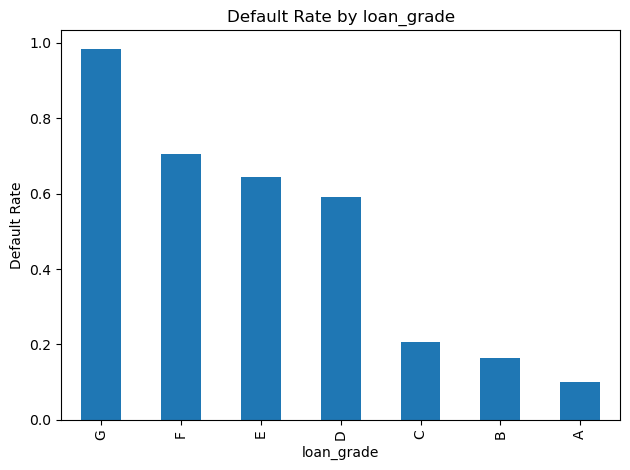

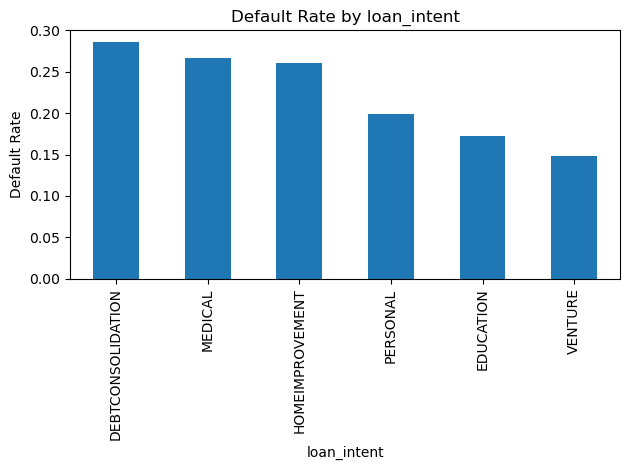

Saved charts in ../screenshots/


In [4]:
#Charts
# Chart 1: Default rate by loan_grade
tmp = df.groupby("loan_grade")["loan_status"].mean().sort_values(ascending=False)
plt.figure()
tmp.plot(kind="bar")
plt.title("Default Rate by loan_grade")
plt.ylabel("Default Rate")
plt.tight_layout()
plt.savefig("../screenshots/eda_default_by_grade.png", dpi=200)
plt.show()

# Chart 2: Default rate by loan_intent
tmp2 = df.groupby("loan_intent")["loan_status"].mean().sort_values(ascending=False)
plt.figure()
tmp2.plot(kind="bar")
plt.title("Default Rate by loan_intent")
plt.ylabel("Default Rate")
plt.tight_layout()
plt.savefig("../screenshots/eda_default_by_intent.png", dpi=200)
plt.show()

print("Saved charts in ../screenshots/")

In [5]:
# Step 5 - Feature setup + Train/Test split

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

X = df.drop(columns=["loan_status"])
y = df["loan_status"]

cat_cols = ["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"]
num_cols = [c for c in X.columns if c not in cat_cols]

# OneHot for categorical + Scaling for numeric (fixes Logistic warning)
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (26064, 11) Test: (6517, 11)


In [9]:
# Step 6 - Train models + Evaluate (3 models)
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
!pip install xgboost
from xgboost import XGBClassifier


In [11]:
def evaluate_model(name, model):
    model.fit(X_train, y_train)

    prob = model.predict_proba(X_test)[:, 1]
    pred = (prob >= 0.5).astype(int)

    roc = roc_auc_score(y_test, prob)

    print("\n" + "="*60)
    print("MODEL:", name)
    print("ROC-AUC:", round(roc, 4))
    print("Confusion Matrix:\n", confusion_matrix(y_test, pred))
    print("Classification Report:\n", classification_report(y_test, pred))

    return roc, model

In [13]:
# Logistic Regression 
log_model = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=5000, solver="lbfgs"))
])

log_roc, log_model = evaluate_model("Logistic Regression", log_model)


MODEL: Logistic Regression
ROC-AUC: 0.8693
Confusion Matrix:
 [[4852  243]
 [ 623  799]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92      5095
           1       0.77      0.56      0.65      1422

    accuracy                           0.87      6517
   macro avg       0.83      0.76      0.78      6517
weighted avg       0.86      0.87      0.86      6517



In [15]:
# Random Forest 
rf_model = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    ))
])

rf_roc, rf_model = evaluate_model("Random Forest", rf_model)


MODEL: Random Forest
ROC-AUC: 0.9325
Confusion Matrix:
 [[5072   23]
 [ 406 1016]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      5095
           1       0.98      0.71      0.83      1422

    accuracy                           0.93      6517
   macro avg       0.95      0.85      0.89      6517
weighted avg       0.94      0.93      0.93      6517



In [12]:
# XGBoost
xgb_model = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", XGBClassifier(
        n_estimators=400,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric="logloss",
        random_state=42 ))
])
xgb_roc, xgb_model = evaluate_model("XGBoost", xgb_model)


MODEL: XGBoost
ROC-AUC: 0.9445
Confusion Matrix:
 [[5060   35]
 [ 401 1021]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      5095
           1       0.97      0.72      0.82      1422

    accuracy                           0.93      6517
   macro avg       0.95      0.86      0.89      6517
weighted avg       0.94      0.93      0.93      6517



In [16]:
# Step 7 - Pick Best Model + Risk Band segmentation + Export for Power BI
# Choose best model by ROC-AUC
scores = {"log": log_roc, "rf": rf_roc, "xgb": xgb_roc}
best_key = max(scores, key=scores.get)

best_model = {"log": log_model, "rf": rf_model, "xgb": xgb_model}[best_key]
print("Best model:", best_key, "| ROC-AUC:", round(scores[best_key], 4))

# Score full dataset
df_scored = df.copy()
df_scored["default_probability"] = best_model.predict_proba(
    df_scored.drop(columns=["loan_status"])
)[:, 1]

# Risk band logic
def band(p):
    if p < 0.20:
        return "Low"
    elif p < 0.50:
        return "Medium"
    else:
        return "High"

df_scored["risk_band"] = df_scored["default_probability"].apply(band)

print(df_scored["risk_band"].value_counts())

# Save scored file for Power BI
df_scored.to_csv("../data_scored/credit_risk_scored.csv", index=False)
print("Saved: ../data_scored/credit_risk_scored.csv")

Best model: xgb | ROC-AUC: 0.9445
risk_band
Low       24801
High       5314
Medium     2466
Name: count, dtype: int64
Saved: ../data_scored/credit_risk_scored.csv


In [17]:
# Step 8 - Save Model 
import joblib
joblib.dump(best_model, "../models/best_model_pipeline.pkl")
print("Saved model: ../models/best_model_pipeline.pkl")

Saved model: ../models/best_model_pipeline.pkl
